In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [3]:
df = pd.read_csv(
    'perrin-freres-monthly-champagne.csv',
    index_col='Month',
    skipfooter=2,
    parse_dates=True
)

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """


In [4]:
df.columns = ['Sales']

In [5]:
df['LogSales'] = np.log(df['Sales'])

In [6]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [8]:
series = df['LogSales'].to_numpy()

In [9]:
T = 10 # number of lags
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (95, 10) Y.shape (95,)


In [10]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [11]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.5394279536653952

In [12]:
lr.score(Xtest, Ytest)

0.5053054507257924

In [13]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False

In [14]:
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

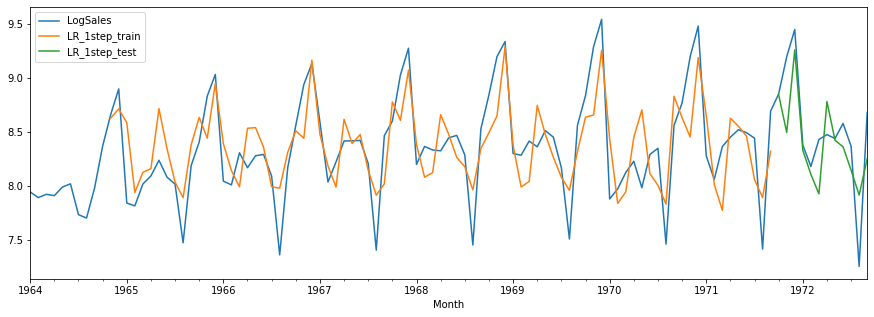

In [16]:
df[['LogSales',
    'LR_1step_train',
    'LR_1step_test']].plot(figsize=(15,5));

In [17]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = lr.predict(last_x.reshape(1, -1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [18]:
# save multistep forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

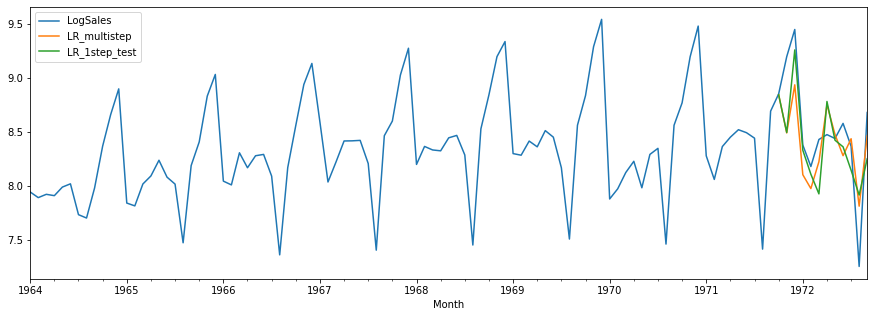

In [19]:
df[['LogSales',
    'LR_multistep',
    'LR_1step_test']].plot(figsize=(15,5));

In [20]:
# make multi-output supervised dataset
Tx = T # number of step in the input
Ty = Ntest # number of steps in the output
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (84, 10) Y.shape (84, 12)


In [21]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [22]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8245363553902466

In [23]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.8765260159920705

In [24]:
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

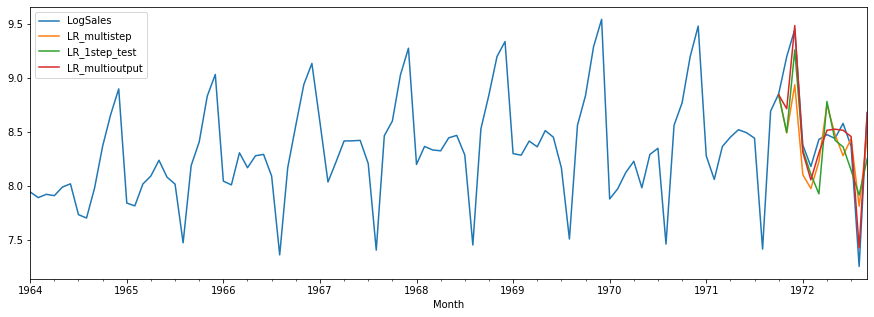

In [25]:
# plot all forecasts
cols = ['LogSales', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15,5));

In [26]:
# MAPE
test_log_loss = df.iloc[-Ntest:]['LogSales']
mape1 = mean_absolute_percentage_error(test_log_loss, df.loc[test_idx, 'LR_multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_loss, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.03301598002036186
multi-output MAPE: 0.01267415658930913


In [29]:
def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)

    # store l-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
    df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

    # generate multi-step forecast
    multistep_predictions = []

    # first test input
    last_x = Xtest[0]

    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1,-1))[0]

        # update the predictions list
        multistep_predictions.append(p)

        # make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p

    # store multi-strp forecast
    df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
    print("Test MAPE (multi-step):", mape)

    # plot 1-step and multi-step forecast
    cols = [
        'LogSales',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test'
    ]
    df[cols].plot(figsize=(15,5));

One-step forecast: SVR
Test MAPE (multi-step): 0.014959980225026545


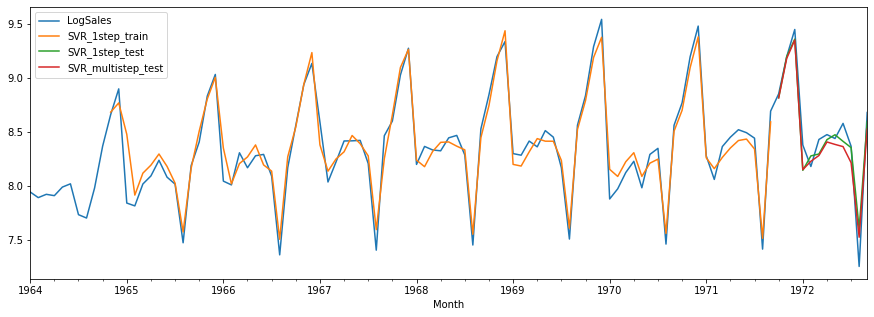

In [30]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.012270242947317316


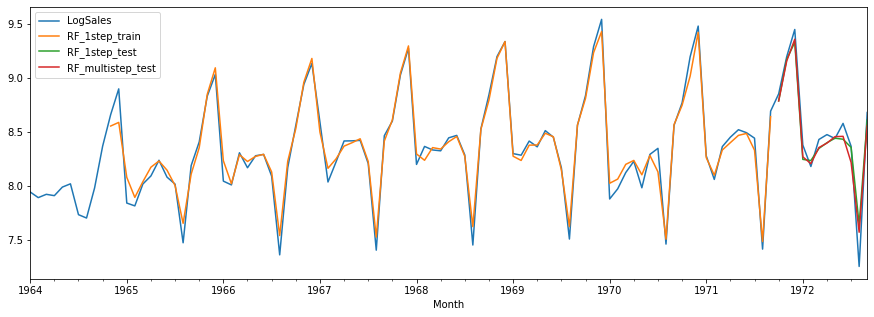

In [31]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [32]:
def multi_output_forecast(model, name):
    model.fit(Xtrain_m, Ytrain_m)

    # save multi-output forecast to dataframe
    df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()

    mape = mean_absolute_percentage_error(
        test_log_loss, df.loc[test_idx, f'{name}_multioutput']
    )
    print("Test MAPE (multi-output):", mape)

    # plot all forecasts
    # assume that previous functions have been run
    cols = [
        'LogSales',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput'
    ]
    df[cols].plot(figsize=(15,5));

Test MAPE (multi-output): 0.019788873473113953


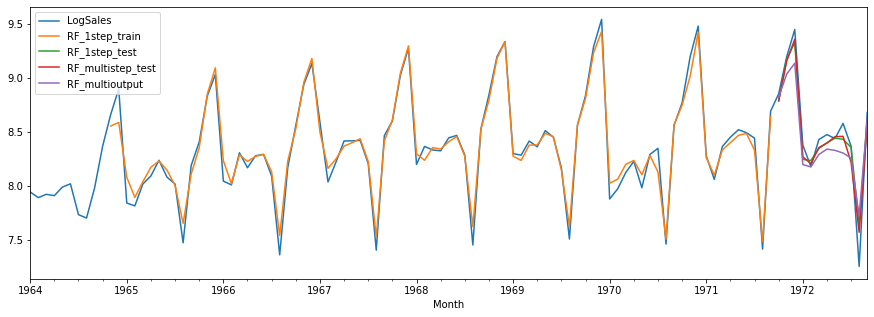

In [33]:
multi_output_forecast(RandomForestRegressor(), "RF")